In [1]:
import Pkg; Pkg.add("DifferentialEquations")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [2]:
import Pkg; Pkg.add("SpecialFunctions")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [3]:
import Pkg; Pkg.add("QuadGK")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [4]:
import Pkg
Pkg.add("SphericalFunctions")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [5]:
using SphericalFunctions
names(SphericalFunctions)


74-element Vector{Symbol}:
 :ALFRecursionCoefficients
 :ALFcompute
 :ALFcompute!
 :ALFrecurse!
 :D!
 :D_iterator
 :D_matrices
 :D_matrices!
 :D_prep
 :Diterator
 :Dprep
 :H!
 :H_recursion_coefficients
 ⋮
 :sYlm_prep
 :sYlm_values
 :sYlm_values!
 :sorted_ring_pixels
 :sorted_ring_rotors
 :sorted_rings
 :theta_phi
 :ð
 :ð̄
 :λ_iterator
 :λiterator
 :ₛ𝐘

In [6]:
using DifferentialEquations, SpecialFunctions, LinearAlgebra, Plots,QuadGK,SphericalFunctions

In [35]:
# Parameters
l_max = 10
num_modes = (l_max + 1)^2

# Initial conditions
c0 = zeros(Float64, num_modes)
cdot0 = zeros(Float64, num_modes)

# Laplacian eigenvalues ( I learnt this from ChatGPT :) )
function compute_laplacian_eigenvalues(lmax)
    index = 1
    eigenvalues = zeros(Float64, (lmax + 1)^2)
    for l in 0:lmax
        for m in -l:l
            eigenvalues[index] = -l * (l + 1)
            index += 1
        end
    end
    return eigenvalues
end

Laplacian_eigen_value = compute_laplacian_eigenvalues(l_max)

# Wave Equation System: ∂tϕ = ψ, ∂tψ = Δϕ
function wave_equation!(du, u, p, t)
    n_max = length(u) ÷ 2
    c = u[1:n_max]
    cdot = u[n_max+1:end]

    du[1:n_max] .= cdot                           # ∂tϕ = ψ
    du[n_max+1:end] .= Laplacian_eigen_value .* c # ∂tψ = Δϕ

    # Debugging print statements
    if t < 0.01  # To avoid flooding the output
        println("At time t=$t, c[4] = ", c[4], ", cdot[4] = ", cdot[4])
    end
end


wave_equation! (generic function with 1 method)

At time t=0.0, c[4] = 0.0, cdot[4] = 0.0
At time t=0.0, c[4] = 0.0, cdot[4] = 0.0
At time t=0.0025, c[4] = 0.0, cdot[4] = 0.0
At time t=0.006095388811015179, c[4] = 0.0, cdot[4] = 0.0


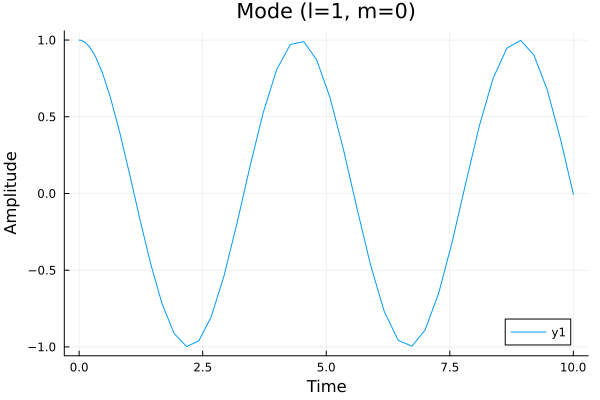

In [36]:
# Example: excite the (l=1, m=0) mode
c0[2] = 1.0  


u0 = vcat(c0, cdot0)                  
tspan = (0.0, 10.0)                    
prob = ODEProblem(wave_equation!, u0, tspan)
sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6)


plot(sol.t, sol[2, :], xlabel="Time", ylabel="Amplitude", title="Mode (l=1, m=0)")


In [29]:
# Width of Gaussian
σ = 0.2  

# Gaussian-like function around the North Pole
function gaussian_peak(θ)
    return exp(-θ^2 / (2 * σ^2))
end
    

gaussian_peak (generic function with 1 method)

In [30]:
function compute_initial_coeffs(l_max)
    c0 = zeros(Float64, num_modes)
    index = 1

    for l in 0:l_max
        for m in -l:l
            
            if m == 0 
                Ylm = θ -> real(sYlm_values(θ, 0.0, l, m)[1])
                #real(sYlm_values(0.0, l, m, θ)[1]) ### here! how to use Ylm?

                integrand(θ) = gaussian_peak(θ) * Ylm(θ) * sin(θ)
                c_l, _ = quadgk(integrand, 0, π)
                c0[index] = c_l
            end
            index += 1
        end
    end
    return c0
end


compute_initial_coeffs (generic function with 1 method)

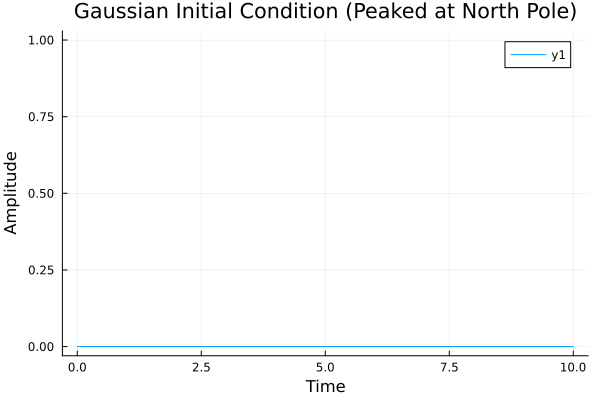

In [34]:
# Initial conditions
l_max = 10
num_modes = (l_max + 1)^2

c0 = compute_initial_coeffs(l_max )
cdot0 = zeros(Float64, num_modes)
 
# ODE Solver Setup
u0 = vcat(c0, cdot0)
tspan = (0.0, 10.0)
prob = ODEProblem(wave_equation!, u0, tspan)
sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6)

# Plotting the evolution of the dominant mode (e.g., l = 2, m = 0)
plot(sol.t, sol[4, :], xlabel="Time", ylabel="Amplitude", 
     title="Gaussian Initial Condition (Peaked at North Pole)")

In [23]:
println(c0)


[0.011134537872504529, 0.0, 0.011134537872504529, 0.0, 0.0, 0.0, 0.011134537872504529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011134537872504529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011134537872504529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011134537872504529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011134537872504529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011134537872504529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011134537872504529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011134537872504529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011134537872504529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [24]:
println(Laplacian_eigen_value[4])


-2.0


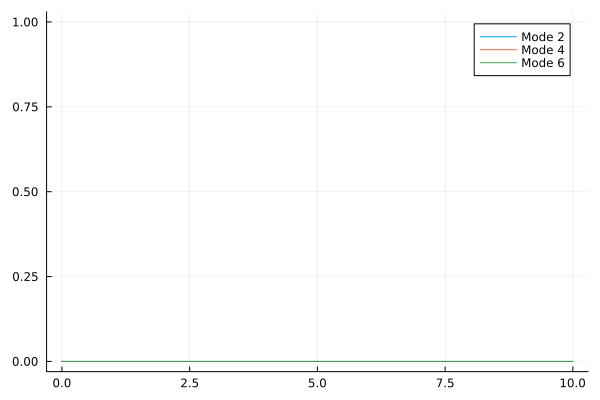

In [26]:
plot(sol.t, sol[2, :], label="Mode 2")
plot!(sol.t, sol[4, :], label="Mode 4")
plot!(sol.t, sol[6, :], label="Mode 6")


In [20]:
using SphericalFunctions

# Example for l=2, m=0
l = 2
m = 0
θ = π/4   # Example theta
ϕ = 0     # Example phi

# Compute the spherical harmonic Yₗᵐ(θ, ϕ)
Ylm_value = Ylm(l, m, θ, ϕ)
println(Ylm_value)


LoadError: UndefVarError: `Ylm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.